---
Modelo PPO para CartPole (En desarrollo)
---


## Proximal Policy Optimization (PPO)

Proximal Policy Optimization (PPO) es un algoritmo de aprendizaje por refuerzo (RL) basado en políticas que equilibra eficiencia y simplicidad. Fue introducido por OpenAI y ha ganado popularidad por su robustez y facilidad de implementación. PPO es una mejora del algoritmo Trust Region Policy Optimization (TRPO), que simplifica la actualización de políticas mediante la introducción de un enfoque basado en límites de probabilidad relativa (clip).

### Descripción matemática

PPO maximiza la función de ventaja estimada  A(s, a) , restringiendo las actualizaciones de la política para evitar cambios drásticos. Formalmente, el objetivo es:


$$L^{CLIP}(\theta) = \mathbb{E}_t \Big[ \min \Big( r_t(\theta) A_t, \text{clip}(r_t(\theta), 1 - \epsilon, 1 + \epsilon) A_t \Big) \Big]$$

1.	Cálculo del ratio de probabilidad:

$$r_t(\theta) = \frac{\pi_\theta(a_t | s_t)}{\pi_{\theta_{\text{old}}}(a_t | s_t)}$$

donde:

$\pi_\theta(a_t | s_t)$ : política actual que genera acción  $a_t $ dado estado  $s_t$ .

$\pi_{\theta_{\text{old}}}(a_t | s_t)$ : política anterior.
	
2.	Clip del ratio:
Se restringen los cambios del ratio a  $[1 - \epsilon, 1 + \epsilon]$  para mantener la estabilidad del aprendizaje.
$ \text{clip}(r_t(\theta), 1 - \epsilon, 1 + \epsilon)$  aplica esta restricción.

3.	Ventaja estimada $( A_t )$:
Se calcula usando el valor esperado  $V(s_t)$ :

$$A_t = \delta_t + \gamma \delta_{t+1} + \dots + \gamma^k \delta_{t+k}$$

donde:

$$\delta_t = r_t + \gamma V(s_{t+1}) - V(s_t)$$

4.	Actualización del parámetro:

$$\theta \leftarrow \theta + \alpha \nabla_\theta L^{CLIP}(\theta)$$

El objetivo es maximizar $ L^{CLIP}(\theta)$ , sujeto a las restricciones impuestas por el “clip”, para evitar oscilaciones inestables en la política.

In [10]:
import gym
import torch
import torch.nn as nn
from torch.distributions import Categorical
import torch.optim as optim
import matplotlib.pyplot as plt
from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib import animation

In [11]:
# Definir la red de política
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim, action_dim)
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu2(self.fc2(x))
        action_probs = self.softmax(self.fc3(x))
        return action_probs

In [12]:
# Definir la red de valor
class ValueNetwork(nn.Module):
    def __init__(self, state_dim, hidden_dim=128):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        state_value = self.fc2(x)
        return state_value

In [13]:
# Función para recolectar trayectorias
def collect_trajectories(env, policy_net, value_net, timesteps):
    states = []
    actions = []
    rewards = []
    dones = []
    log_probs = []
    state_values = []
    
    state, _ = env.reset()
    for _ in range(timesteps):
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        action_probs = policy_net(state_tensor)
        dist = Categorical(action_probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        value = value_net(state_tensor)
        
        next_state, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated or truncated
        
        # Almacenar los datos (desconectar log_prob)
        states.append(state)
        actions.append(action.item())
        rewards.append(reward)
        dones.append(done)
        log_probs.append(log_prob.detach())
        state_values.append(value.detach())
        
        state = next_state
        if done:
            state, _ = env.reset()
    return states, actions, rewards, dones, log_probs, state_values

In [14]:
# Calcular ventajas y retornos
def compute_gae(rewards, state_values, dones, gamma=0.99, lam=0.95):
    advantages = []
    gae = 0
    next_value = 0  # Valor cero para el estado final
    state_values = [sv.item() for sv in state_values]
    for i in reversed(range(len(rewards))):
        mask = 1 - dones[i]
        delta = rewards[i] + gamma * next_value * mask - state_values[i]
        gae = delta + gamma * lam * gae * mask
        advantages.insert(0, gae)
        next_value = state_values[i]
    return advantages

In [15]:
# Función de actualización PPO
def ppo_update(policy_net, value_net, optimizer_policy, optimizer_value, states, actions, log_probs_old, returns, advantages, clip_epsilon=0.2, epochs=10):
    states = torch.FloatTensor(states)
    actions = torch.LongTensor(actions)
    log_probs_old = torch.stack(log_probs_old)
    returns = torch.FloatTensor(returns)
    advantages = torch.FloatTensor(advantages)
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)  # Normalización

    entropy_coef = 0.05 # Ajusta este valor

    for _ in range(epochs):
        # Obtener las nuevas probabilidades de acción
        action_probs = policy_net(states)
        dist = Categorical(action_probs)
        log_probs = dist.log_prob(actions)
        entropy = dist.entropy().mean()
        
        # Calcular el ratio
        ratios = torch.exp(log_probs - log_probs_old)
        
        # Calcular las pérdidas
        surr1 = ratios * advantages
        surr2 = torch.clamp(ratios, 1 - clip_epsilon, 1 + clip_epsilon) * advantages
        loss_policy = -torch.min(surr1, surr2).mean() - entropy_coef * entropy  # Incluye término de entropía
        
        # Actualizar la red de política
        optimizer_policy.zero_grad()
        loss_policy.backward()
        optimizer_policy.step()
        
        # Actualizar la red de valor
        values = value_net(states).squeeze()
        loss_value = nn.MSELoss()(values, returns)
        
        optimizer_value.zero_grad()
        loss_value.backward()
        optimizer_value.step()

In [16]:
# Función para probar el agente
def test_agent(env, policy_net, num_episodes=5):
    total_rewards = []
    for _ in range(num_episodes):
        state, _ = env.reset()
        done = False
        episode_reward = 0
        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                action_probs = policy_net(state_tensor)
            action = torch.argmax(action_probs, dim=-1).item()
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_reward += reward
            state = next_state
        total_rewards.append(episode_reward)
    return sum(total_rewards) / num_episodes

In [17]:
# Función para visualizar el agente
def visualize_agent(env, policy_net):
    frames = []
    state, _ = env.reset()
    done = False
    while not done:
        # Obtener frame del entorno
        frame = env.render()
        frames.append(frame)
        
        # Seleccionar acción según la política entrenada
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            action_probs = policy_net(state_tensor)
        action = torch.argmax(action_probs, dim=-1).item()
        
        # Ejecutar acción en el entorno
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
    
    env.close()
    
    # Crear animación
    fig = plt.figure()
    plt.axis('off')
    ims = []
    for frame in frames:
        im = plt.imshow(frame, animated=True)
        ims.append([im])
    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True)
    plt.close()
    display(HTML(ani.to_html5_video()))

In [18]:
env = gym.make('CartPole-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

policy_net = PolicyNetwork(state_dim, action_dim)
value_net = ValueNetwork(state_dim)

# Bucle de entrenamiento principal

optimizer_policy = optim.Adam(policy_net.parameters(), lr=3e-5)
optimizer_value = optim.Adam(value_net.parameters(), lr=1e-4)

num_updates = 200
timesteps_per_batch = 2048
gamma = 0.99
lam = 0.95
clip_epsilon = 0.1
epochs = 15

# Lista para almacenar recompensas promedio
average_rewards = []

for update in range(num_updates):
    # Recolectar trayectorias
    states, actions, rewards, dones, log_probs_old, state_values = collect_trajectories(env, policy_net, value_net, timesteps_per_batch)
    
    # Calcular ventajas y retornos
    advantages = compute_gae(rewards, state_values, dones, gamma, lam)
    returns = [adv + val for adv, val in zip(advantages, state_values)]
    
    # Actualizar las redes
    ppo_update(policy_net, value_net, optimizer_policy, optimizer_value, states, actions, log_probs_old, returns, advantages, clip_epsilon, epochs)
    
    # Monitorear el progreso
    if update % 10 == 0:
        total_reward = test_agent(env, policy_net)
        average_rewards.append(total_reward)
        print(f'Actualización {update}, Recompensa Promedio: {total_reward}')

Actualización 0, Recompensa Promedio: 11.6
Actualización 10, Recompensa Promedio: 81.8
Actualización 20, Recompensa Promedio: 144.8
Actualización 30, Recompensa Promedio: 122.2
Actualización 40, Recompensa Promedio: 217.0
Actualización 50, Recompensa Promedio: 184.6
Actualización 60, Recompensa Promedio: 359.0
Actualización 70, Recompensa Promedio: 288.6
Actualización 80, Recompensa Promedio: 443.4
Actualización 90, Recompensa Promedio: 370.6
Actualización 100, Recompensa Promedio: 248.8
Actualización 110, Recompensa Promedio: 416.4
Actualización 120, Recompensa Promedio: 445.6
Actualización 130, Recompensa Promedio: 281.0
Actualización 140, Recompensa Promedio: 281.8
Actualización 150, Recompensa Promedio: 323.4
Actualización 160, Recompensa Promedio: 305.8
Actualización 170, Recompensa Promedio: 289.4
Actualización 180, Recompensa Promedio: 268.0
Actualización 190, Recompensa Promedio: 240.0


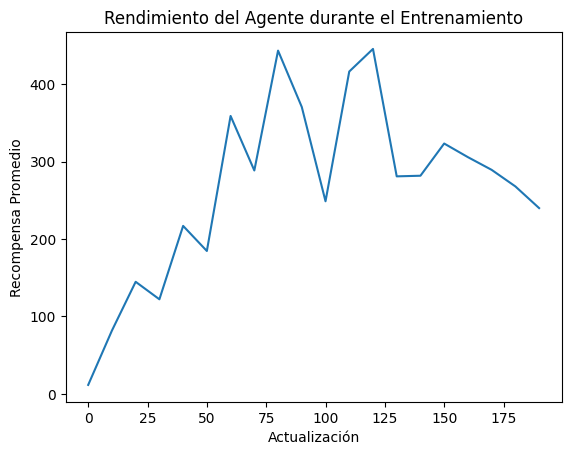

In [19]:
# Graficar las recompensas
plt.plot(range(0, num_updates, 10), average_rewards)
plt.xlabel('Actualización')
plt.ylabel('Recompensa Promedio')
plt.title('Rendimiento del Agente durante el Entrenamiento')
plt.show()

In [20]:
env = gym.make('CartPole-v1', render_mode='rgb_array')
visualize_agent(env, policy_net)

/Users/christian/.pyenv/versions/3.9.7/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
